In [1]:
import pycomlink as pycml

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# Load data
TODO: Use some of the OPENSENSE CML data, maybe OpenMRG

In [3]:
data_path = pycml.io.examples.get_example_data_path()

cmls = xr.open_dataset(data_path + '/example_cml_data.nc')
cmls

<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object 'FY0013_2_FY1257_3' ... 'SY8534_2_SY237...
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) object ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

# Set default and fill values to NaN and calculate TRSL

Short gaps (<= 5min) in the time series will be interpolated
TRSL is the transmitted signal level minus the received signal level and represents the total path loss along the CML

In [4]:
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['tsl'] = cmls.tsl.interpolate_na(dim='time', method='linear', max_gap='5min')
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['rsl'] = cmls.rsl.interpolate_na(dim='time', method='linear', max_gap='5min')
cmls['trsl'] = cmls.tsl - cmls.rsl

# Basic CML processing
TODO: Extend to full processing. This is just to show that pycomlink works here.

In [5]:
# get CMLs as list from xarray.Dataset because we want to iterate over them later
cml_list = [cmls.isel(cml_id=i) for i in range(len(cmls.cml_id))]

In [6]:
from pycomlink.processing.wet_dry.cnn import cnn_wet_dry

cml = cml_list[0]

# Wet-dry using CNN method
cnn_wet_dry = cnn_wet_dry(
    trsl_channel_1=cml.trsl.isel(channel_id=0).values,
    trsl_channel_2=cml.trsl.isel(channel_id=1).values,
)
cml['wet'] = (('time'), cnn_wet_dry > 0.8)

# Wet-dry using rolling std-dev method
# roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
# cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > 0.8

2022-10-16 21:27:16.906945: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/chwala-c/mambaforge/envs/opensense_sandbox/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


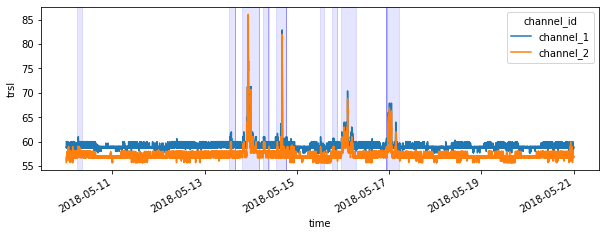

In [7]:
fig, ax = plt.subplots(figsize=(10,3))

cml.trsl.plot.line(x='time', ax=ax);

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax.axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

ax.set_title('');